In [1]:
# imports
import os
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from ml4cc.models import LSTM
from ml4cc.tools.evaluation import peakFinding as pf
from ml4cc.data.FCC import dataloader as fdl
from ml4cc.data.CEPC import dataloader as cdl

In [2]:
with initialize(version_base=None, config_path="../config", job_name="test_app"):
    cfg = compose(config_name="training")

In [3]:
# FCC eval:
FCC_RESULT_OUTPUT_DIR = "/home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/"
os.makedirs(FCC_RESULT_OUTPUT_DIR, exist_ok=True)
FCC_BEST_MODEL_PATH = "/home/laurits/ml4cc/training-outputs/20250103_FCC_350_epoch/models/peakFinding-epoch=218-val_loss=0.02.ckpt"
FCC_METRICS_PATH = "/home/laurits/ml4cc/training-outputs/20250103_FCC_350_epoch/logs/peakFinding/version_0/metrics.csv"

model = LSTM.LSTMModule.load_from_checkpoint(FCC_BEST_MODEL_PATH, weights_only=True)
model.eval()

FCC_ENERGIES = [2, 4, 6, 8, 10, 165, 180]
FCC_BASE_TEST_DIR = "/scratch/persistent/laurits/ml4cc/FCC/preprocessed_data/test/"

for energy in FCC_ENERGIES:
    data_path = os.path.join(FCC_BASE_TEST_DIR, f"{energy}_1.parquet")
    test_dataset = fdl.IterableFCCDataset(
        data_path=data_path,
        cfg=cfg,
        dataset_type="test",
    )
    output_dir = os.path.join(FCC_RESULT_OUTPUT_DIR, str(energy))
    os.makedirs(output_dir, exist_ok=True)
    test_loader = DataLoader(test_dataset, batch_size=80)
    pf.evaluate_training(
        model=model,
        dataloader=test_loader,
        metrics_path=FCC_METRICS_PATH,
        cfg=cfg,
        output_dir=output_dir
    )

/opt/conda/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/uti

There are 4,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15
Prediction progress for TEST dataset


100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [01:09<00:00, 57.86it/s]


Saving 4000 processed entries to /home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/2/predictions.parquet
There are 4,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15
Prediction progress for TEST dataset


100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [01:09<00:00, 57.87it/s]


Saving 4000 processed entries to /home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/4/predictions.parquet
There are 4,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15
Prediction progress for TEST dataset


100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [01:08<00:00, 58.43it/s]


Saving 4000 processed entries to /home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/6/predictions.parquet
There are 4,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15
Prediction progress for TEST dataset


100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [01:08<00:00, 58.53it/s]


Saving 4000 processed entries to /home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/8/predictions.parquet
There are 4,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15
Prediction progress for TEST dataset


100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [01:08<00:00, 58.09it/s]


Saving 4000 processed entries to /home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/10/predictions.parquet
There are 4,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15
Prediction progress for TEST dataset


100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [01:08<00:00, 58.14it/s]


Saving 4000 processed entries to /home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/165/predictions.parquet
There are 4,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15
Prediction progress for TEST dataset


100%|██████████████████████████████████████████████████████████████████████████| 4000/4000 [01:08<00:00, 58.33it/s]


Saving 4000 processed entries to /home/laurits/tmp/20250107_FCC_peakFinding_350_epoch/180/predictions.parquet


In [4]:
import awkward as ak
import matplotlib
import boost_histogram as bh
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep

In [5]:
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

def plot_histograms(num_true_peaks, num_pred_peaks, output_path):
    bins = np.linspace(0, 40, 20)
    plt.hist(num_true_peaks, bins=bins, histtype='step', hatch='//', label='true')
    plt.hist(num_pred_peaks, bins=bins, histtype='step', hatch='\\', label='pred')
    plt.legend()
    plt.grid()
    plt.ylabel('Number entrier / bin')
    plt.xlabel('Number peaks')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close('all')

def plot_ratios(ratios, output_path):
    bins = np.linspace(0.5, 1.5, 15)
    hep.histplot(to_bh(ratios, bins=bins), density=True)
    plt.grid()
    plt.ylabel('Number entrier / bin')
    plt.xlabel('#predicted peaks / #generated peaks')
    plt.savefig(output_path, bbox_inches='tight')
    plt.close('all')

In [6]:
# Count the number of true and detected primary clusters after the peak finding
for energy in FCC_ENERGIES:
    pred_path = os.path.join(FCC_RESULT_OUTPUT_DIR, str(energy), "predictions.parquet")
    data = ak.from_parquet(pred_path)
    pred = data.detected_peaks
    true = data.target
    num_true_peaks = ak.sum(true == 1, axis=-1)
    num_pred_peaks = ak.sum(pred == 1, axis=-1)
    ratios = num_pred_peaks / num_true_peaks
    histo_output_path = os.path.join(FCC_RESULT_OUTPUT_DIR, str(energy), "pred_true_distributions.png")
    plot_histograms(num_true_peaks, num_pred_peaks, histo_output_path)
    ratio_output_path = os.path.join(FCC_RESULT_OUTPUT_DIR, str(energy), "pred_true_ratio_distribution.png")
    plot_ratios(ratios, ratio_output_path)

In [11]:
results_auc = {
    2: 0.9876,
    4: 0.9889,
    6: 0.9886,
    8: 0.9891,
    10: 0.9890,
    165: 0.9889,
    180: 0.9888
}


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.styles.CMS)

def plot_performances(performances: dict, mean: int = None):
    if mean is None:
        mean = np.mean(list(performances.values()))
    fig, ax = plt.subplots()
    labels = [f"{i} GeV" for i in list(performances.keys())]
    x_values = np.arange(len(performances.values()))
    auc_values = np.array(list(performances.values()))

    ax.set_xticks(np.arange(len(performances.values())))
    ax.set_xticklabels(labels)
    plt.xticks(rotation=90)
    
    lower_than_average_mask = auc_values < mean
    for value, loc in zip(auc_values[lower_than_average_mask], x_values[lower_than_average_mask]):
        plt.vlines(loc, ymin=value, ymax=mean, color='red', ls='--')
    for value, loc in zip(auc_values[~lower_than_average_mask], x_values[~lower_than_average_mask]):
        plt.vlines(loc, ymin=mean, ymax=value, color='green', ls='--')
    plt.scatter(x_values[lower_than_average_mask], auc_values[lower_than_average_mask], color='red', s=80)
    plt.scatter(x_values[~lower_than_average_mask], auc_values[~lower_than_average_mask], color='green', s=80)
    plt.axhline(mean, xmin=0, xmax=len(results_auc.values()), ls='--', color='k')

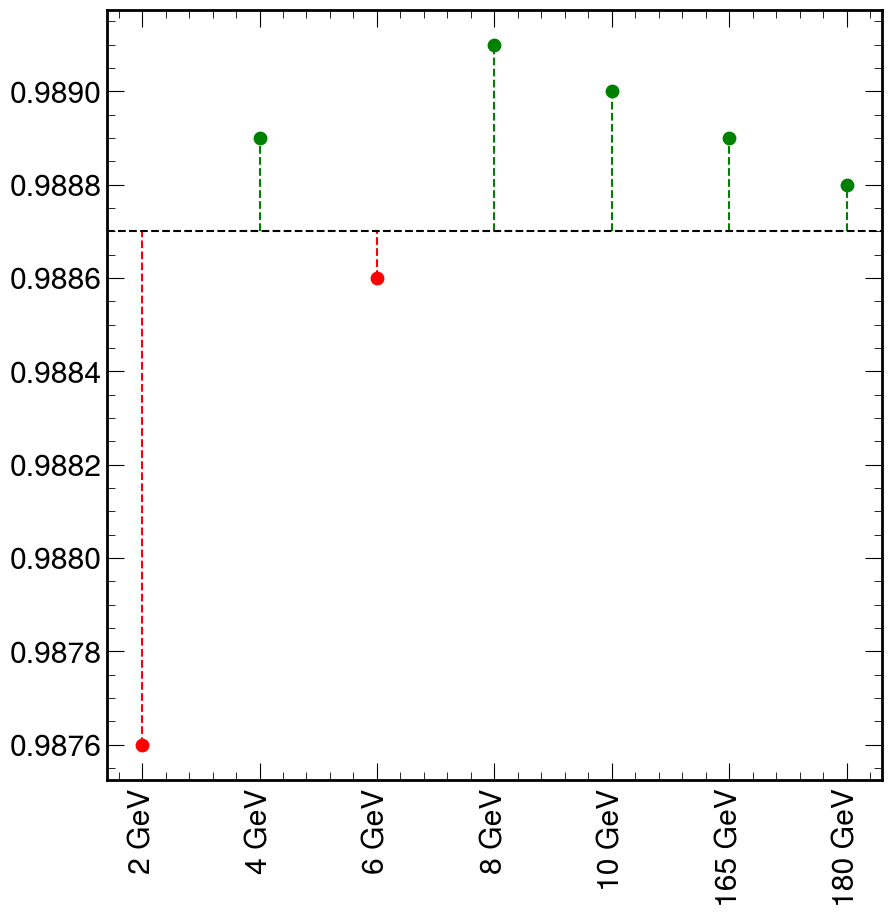

In [13]:
plot_performances(results_auc)

In [27]:
# Evaluate best model before training end
test_data_path = os.path.join(FCC_BASE_TEST_DIR, "*")
full_test_dataset = fdl.IterableFCCDataset(
    data_path=test_data_path,
    cfg=cfg,
    dataset_type="test",
)
os.makedirs('/home/laurits/tmp/full_test_eval', exist_ok=True)
full_test_loader = DataLoader(full_test_dataset, batch_size=80)
pf.evaluate_training(
    model=model,
    dataloader=full_test_loader,
    metrics_path=FCC_METRICS_PATH,
    cfg=cfg,
    output_dir='/home/laurits/tmp/full_test_eval'
)

There are 28,000 waveforms in the test dataset.
Each waveform will be split into sliding windows of size 15


In [31]:
# Load predictions
full_test_pred_data = ak.from_parquet("/home/laurits/tmp/full_test_eval/predictions.parquet")
predicted_peak_count = ak.sum(full_test_pred_data.detected_peaks == 1, axis=-1)
true_peak_count = ak.sum(full_test_pred_data.target == 1, axis=-1)

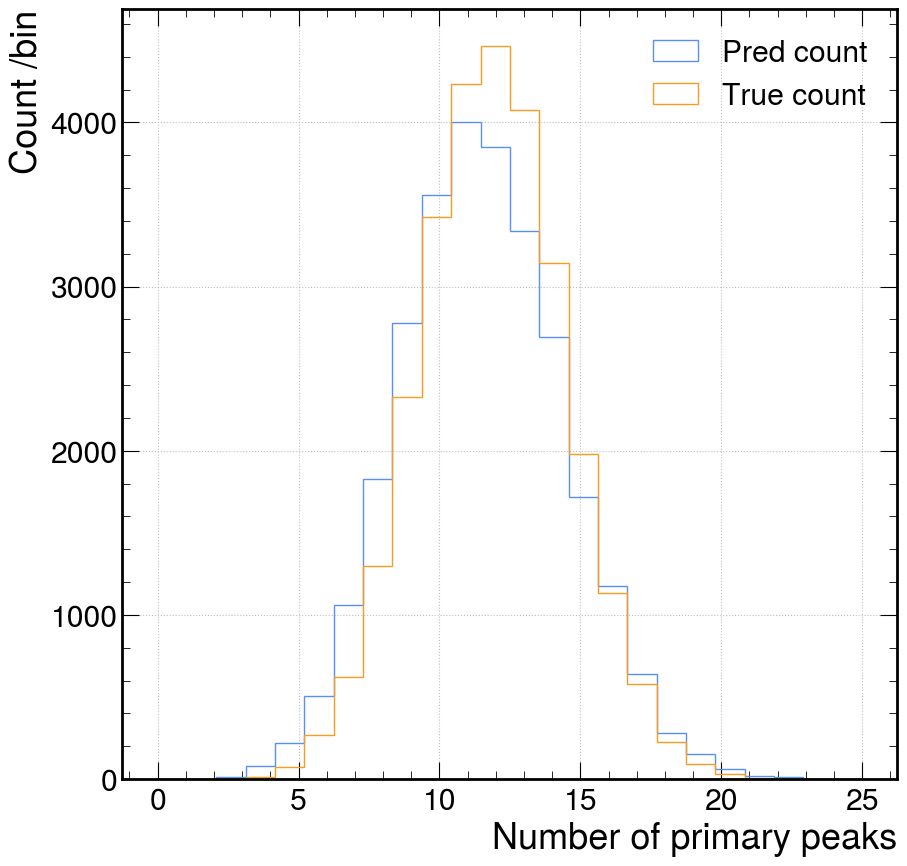

In [36]:
bins = np.linspace(0, 25, num=25)
plt.hist(predicted_peak_count, bins=bins, histtype='step', label="Pred count")
plt.hist(true_peak_count, bins=bins, histtype='step', label="True count")
plt.legend()
plt.xlabel("Number of primary peaks")
plt.ylabel("Count /bin")
plt.grid()

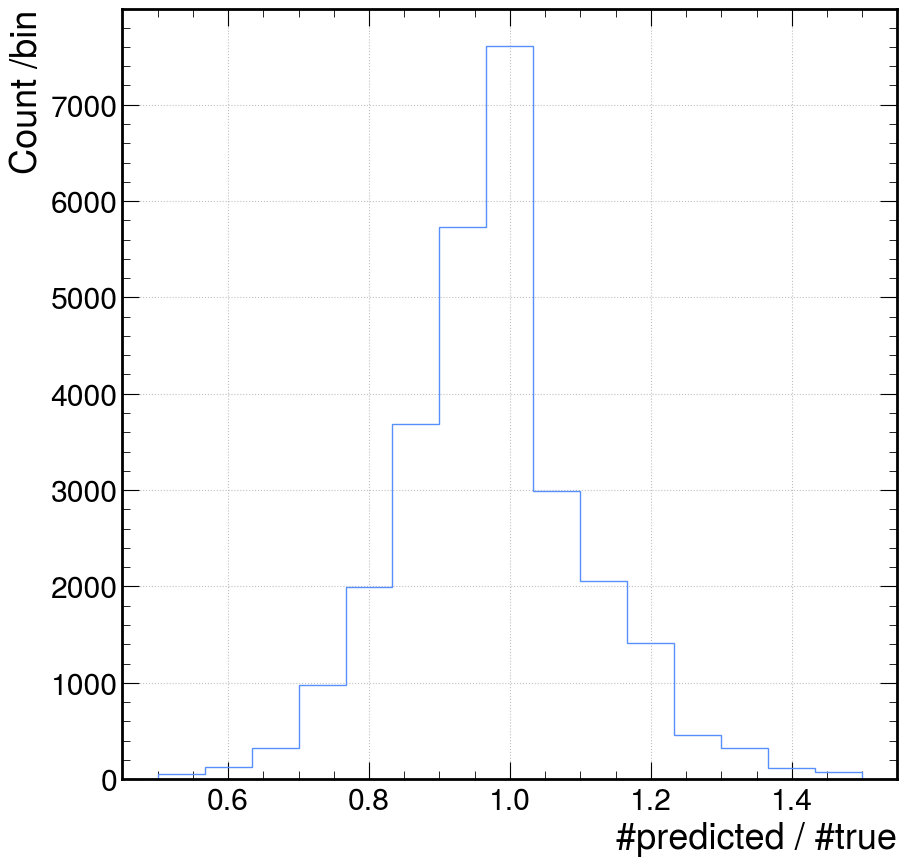

In [49]:
# Calculate resolutions
ratios = predicted_peak_count / true_peak_count

ratio_bins = np.linspace(0.5, 1.5, num=16)
n = plt.hist(ratios, bins=ratio_bins, histtype='step')[0]
plt.xlabel("#predicted / #true")
plt.ylabel("Count /bin")
plt.grid()

In [58]:
def IQR(ratios: np.array) -> np.array:
    return np.quantile(ratios, 0.75) - np.quantile(ratios, 0.25)

In [61]:
median = np.median(ratios)
IQR_ = IQR(ratios)
weighted_IQR = IQR_ / median

print(f"IQR: {IQR_:.3f} \t Median: {median:.3f} \t Resolution: {weighted_IQR:.3f}")

IQR: 0.178 	 Median: 1.000 	 Resolution: 0.178


In [10]:
# # CEPC eval:
# CEPC_RESULT_OUTPUT_DIR = "/home/laurits/tmp/20250104_CEPC_peakFinding/"
# os.makedirs(CEPC_RESULT_OUTPUT_DIR, exist_ok=True)
# CEPC_BEST_MODEL_PATH = "/home/laurits/ml4cc/training-outputs/20241214_150Epoch_LSTM/models/best_model.ckpt"
# CEPC_METRICS_PATH = "/home/laurits/ml4cc/training-outputs/20241214_150Epoch_LSTM/logs/peakFinding/version_0/metrics.csv"

# model = LSTM.LSTMModule.load_from_checkpoint(CEPC_BEST_MODEL_PATH, weights_only=True)
# model.eval()

# CEPC_BASE_TEST_DIR = "/scratch/persistent/laurits/ml4cc/CEPC/preprocessed_data/peakFinding/test/"

# data_path = os.path.join(CEPC_BASE_TEST_DIR, "*")
# dataset = cdl.CEPCDataset(data_path=data_path)
# test_dataset = cdl.IterableCEPCDataset(
#     dataset=dataset,
#     cfg=cfg,
#     dataset_type="test",
# )
# test_loader = DataLoader(test_dataset, batch_size=200)
# pf.evaluate_training(
#     model=model,
#     dataloader=test_loader,
#     metrics_path=CEPC_METRICS_PATH,
#     cfg=cfg,
#     output_dir=CEPC_RESULT_OUTPUT_DIR
# )